<a href="https://colab.research.google.com/github/AndjelijaMladenovic00/Deep_Learning/blob/main/GAN_inpainting_with_augmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image inpainting using GAN and data augmentation

In [5]:
!unzip dataset.zip
import tensorflow as tf
from keras import layers
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
import os
from tqdm import tqdm
from keras.preprocessing.image import img_to_array
import time

Streaming output truncated to the last 5000 lines.
  inflating: dataset/gray/2914.jpg   
  inflating: dataset/gray/2915.jpg   
  inflating: dataset/gray/2916.jpg   
  inflating: dataset/gray/2917.jpg   
  inflating: dataset/gray/2918.jpg   
  inflating: dataset/gray/2919.jpg   
  inflating: dataset/gray/292.jpg    
  inflating: dataset/gray/2920.jpg   
  inflating: dataset/gray/2921.jpg   
  inflating: dataset/gray/2922.jpg   
  inflating: dataset/gray/2923.jpg   
  inflating: dataset/gray/2924.jpg   
  inflating: dataset/gray/2925.jpg   
  inflating: dataset/gray/2926.jpg   
  inflating: dataset/gray/2927.jpg   
  inflating: dataset/gray/2928.jpg   
  inflating: dataset/gray/2929.jpg   
  inflating: dataset/gray/293.jpg    
  inflating: dataset/gray/2930.jpg   
  inflating: dataset/gray/2931.jpg   
  inflating: dataset/gray/2932.jpg   
  inflating: dataset/gray/2933.jpg   
  inflating: dataset/gray/2934.jpg   
  inflating: dataset/gray/2935.jpg   
  inflating: dataset/gray/2936.jpg   

In [6]:
IMAGE_SIZE = 256
BATCH_SIZE = 64

In [7]:
# Definisanje klase za učitavanje slika.
class ImageDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, rgb_path, grayscale_path, batch_size, image_size, image_names, augment=False):
        self.rgb_path = rgb_path
        self.grayscale_path = grayscale_path
        self.batch_size = batch_size
        self.image_size = image_size
        self.image_names = image_names
        self.indexes = np.arange(len(self.image_names))
        self.augment = augment

    def __len__(self):
        return len(self.image_names) // self.batch_size

    def __getitem__(self, index):
        batch_indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        batch_rgb_images = []
        batch_grayscale_images = []

        for i in batch_indexes:
            rgb_image = cv.imread(self.rgb_path + self.image_names[i])
            rgb_image = cv.cvtColor(rgb_image, cv.COLOR_BGR2RGB)
            rgb_image = cv.resize(rgb_image, (self.image_size, self.image_size))
            rgb_image = rgb_image.astype("float32") / 255.0

            grayscale_image = cv.imread(self.grayscale_path + self.image_names[i], cv.IMREAD_GRAYSCALE)
            grayscale_image = cv.resize(grayscale_image, (self.image_size, self.image_size))
            grayscale_image = grayscale_image.astype("float32") / 255.0
            grayscale_image = np.expand_dims(grayscale_image, axis=-1)

            if self.augment:
                rgb_image, grayscale_image = self.augment_data(rgb_image, grayscale_image)

            batch_rgb_images.append(rgb_image)
            batch_grayscale_images.append(grayscale_image)

        return np.array(batch_grayscale_images), np.array(batch_rgb_images)

    def on_epoch_end(self):
        np.random.shuffle(self.indexes)

    def augment_data(self, rgb_image, grayscale_image):
        seed = np.random.randint(1e6)
        tf.random.set_seed(seed)

        # Flip.
        rgb_image = tf.image.random_flip_left_right(rgb_image)
        rgb_image = tf.image.random_flip_up_down(rgb_image)
        grayscale_image = tf.image.random_flip_left_right(grayscale_image)
        grayscale_image = tf.image.random_flip_up_down(grayscale_image)

        # Rotacija.
        angles = [0, 90, 180, 270]
        angle = np.random.choice(angles)
        rgb_image = tf.image.rot90(rgb_image, k=angle // 90)
        grayscale_image = tf.image.rot90(grayscale_image, k=angle // 90)

        return rgb_image, grayscale_image

In [8]:
# Učitavanje putanja slika.
rgb_path = "dataset/color/"
grayscale_path = "dataset/gray/"
image_names = os.listdir(rgb_path)
image_names = sorted(image_names, key=lambda x: int(x.split('.')[0]))

In [9]:
# Podela podataka na trening i test skup podataka i pravljenje generatora podataka.
TRAINING_SIZE = int(len(image_names) * 0.8)
train_image_names = image_names[:TRAINING_SIZE]
test_image_names = image_names[TRAINING_SIZE:]

train_generator = ImageDataGenerator(rgb_path, grayscale_path, BATCH_SIZE, IMAGE_SIZE, train_image_names, augment=True)
test_generator = ImageDataGenerator(rgb_path, grayscale_path, 8, IMAGE_SIZE, test_image_names, augment=False)

In [10]:
# Definisanje funkcija za dodavanje slojeva mreži.
def add_downsampling_layer(filters, size, normalize=True):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv2D(filters, size, strides=2, padding="same", kernel_initializer="he_normal", use_bias=False))
    if normalize:
        model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
    return model

def add_upsampling_layer(filters, size, dropout=False):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv2DTranspose(filters, size, strides=2, padding="same", kernel_initializer="he_normal", use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    if dropout:
        model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.LeakyReLU())
    return model

In [11]:
# Definisanje generatora.
def make_generator():
    inputs = tf.keras.layers.Input(shape=[256, 256, 1])
    downsampling_layers = [
        add_downsampling_layer(64, 4, normalize=False),
        add_downsampling_layer(128, 4),
        add_downsampling_layer(256, 4),
        add_downsampling_layer(512, 4),
        add_downsampling_layer(512, 4),
        add_downsampling_layer(512, 4),
        add_downsampling_layer(512, 4),
        add_downsampling_layer(512, 4),
    ]
    upsampling_layers = [
        add_upsampling_layer(512, 4, dropout=True),
        add_upsampling_layer(512, 4, dropout=True),
        add_upsampling_layer(512, 4, dropout=True),
        add_upsampling_layer(512, 4),
        add_upsampling_layer(256, 4),
        add_upsampling_layer(128, 4),
        add_upsampling_layer(64, 4),
    ]
    last_layer = tf.keras.layers.Conv2DTranspose(3, 4, strides=2, padding="same", kernel_initializer=tf.random_normal_initializer(0., 0.02), activation="tanh")

    x = inputs
    downsampled = []
    for layer in downsampling_layers:
        x = layer(x)
        downsampled.append(x)
    downsampled = downsampled[:-1][::-1]

    for i in range(len(upsampling_layers)):
        x = upsampling_layers[i](x)
        x = tf.keras.layers.Concatenate()([x, downsampled[i]])

    x = last_layer(x)
    return tf.keras.Model(inputs=inputs, outputs=x)

In [12]:
# Definisanje diskriminatora.
def make_discriminator():
    image = tf.keras.layers.Input(shape=[IMAGE_SIZE, IMAGE_SIZE, 1], name="image")
    target = tf.keras.layers.Input(shape=[IMAGE_SIZE, IMAGE_SIZE, 3], name="target")
    inputs = tf.keras.layers.concatenate([image, target])

    downsampled1 = add_downsampling_layer(64, 4, False)(inputs)
    downsampled2 = add_downsampling_layer(128, 4)(downsampled1)
    downsampled3 = add_downsampling_layer(256, 4)(downsampled2)

    padding = tf.keras.layers.ZeroPadding2D()(downsampled3)
    convolution = tf.keras.layers.Conv2D(512, 4, strides=1, kernel_initializer=tf.random_normal_initializer(0., 0.02), use_bias=False)(padding)
    normalization = tf.keras.layers.BatchNormalization()(convolution)
    activation = tf.keras.layers.LeakyReLU()(normalization)
    padding2 = tf.keras.layers.ZeroPadding2D()(activation)
    final = tf.keras.layers.Conv2D(1, 4, strides=1, kernel_initializer=tf.random_normal_initializer(0., 0.02))(padding2)

    return tf.keras.Model(inputs=[image, target], outputs=final)

In [13]:
# Definisanje loss funkcija.
losses = tf.keras.losses.BinaryCrossentropy(from_logits=True)
LAMBDA = 100

def generator_loss(disc_output, gen_output, target):
    gan_loss = losses(tf.ones_like(disc_output), disc_output)
    l1_loss_mean = tf.reduce_mean(tf.abs(target - gen_output))
    total_l1_loss = tf.reduce_sum(tf.abs(target - gen_output))
    gen_loss = gan_loss + LAMBDA * l1_loss_mean
    return gen_loss, gan_loss, l1_loss_mean, total_l1_loss

def discriminator_loss(real, generated):
    real_loss = losses(tf.ones_like(real), real)
    generated_loss = losses(tf.zeros_like(generated), generated)
    disc_loss = real_loss + generated_loss
    return disc_loss

In [14]:
# Inicijalizacija modela.
generator = make_generator()
discriminator = make_discriminator()

In [15]:
# Inicijalizacija optimizatora.
gen_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
disc_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [16]:
# Definisanje jednog koraka treninga.
@tf.function
def training_step(image, target):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_output = generator(image, training=True)
        disc_real_output = discriminator([image, target], training=True)
        disc_generated_output = discriminator([image, gen_output], training=True)

        gen_loss, gan_loss, l1_loss_mean, total_l1_loss = generator_loss(disc_generated_output, gen_output, target)
        disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

        gen_gradients = gen_tape.gradient(gen_loss, generator.trainable_variables)
        disc_gradients = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

        gen_optimizer.apply_gradients(zip(gen_gradients, generator.trainable_variables))
        disc_optimizer.apply_gradients(zip(disc_gradients, discriminator.trainable_variables))

In [17]:
# Definisanje fit metode.
def fit(train_generator, num_epochs):
    for epoch in range(num_epochs):
        start_time = time.time()
        print("Epoch: ", epoch + 1)
        for batch in train_generator:
            grayscale_images, rgb_images = batch
            training_step(grayscale_images, rgb_images)
        print(f"Time taken for epoch {epoch + 1} is {time.time() - start_time} sec\n")


In [18]:
# Definisanje metode za testiranje i evaluaciju.
def test_and_evaluate(test_generator):
    total_l1_loss = 0
    for batch in tqdm(test_generator):
        grayscale_images, rgb_images = batch
        predictions = generator(grayscale_images, training=False)
        _, _, _, l1_loss = generator_loss(discriminator([grayscale_images, predictions], training=False), predictions, rgb_images)
        total_l1_loss += l1_loss.numpy()

    return total_l1_loss

In [19]:
# Treniranje modela.
fit(train_generator, num_epochs=10)

Epoch:  1
Time taken for epoch 1 is 451.86800932884216 sec

Epoch:  2
Time taken for epoch 2 is 410.5020799636841 sec

Epoch:  3
Time taken for epoch 3 is 409.37361454963684 sec

Epoch:  4
Time taken for epoch 4 is 414.5949795246124 sec

Epoch:  5
Time taken for epoch 5 is 411.5098240375519 sec

Epoch:  6
Time taken for epoch 6 is 411.8406493663788 sec

Epoch:  7
Time taken for epoch 7 is 411.3648684024811 sec

Epoch:  8
Time taken for epoch 8 is 411.5987432003021 sec

Epoch:  9
Time taken for epoch 9 is 412.06922483444214 sec

Epoch:  10
Time taken for epoch 10 is 414.5347788333893 sec



In [20]:
# Testiranje i ocena modela.
total_l1_loss = test_and_evaluate(test_generator)
print(f"L1 loss: {total_l1_loss}")

100%|██████████| 178/178 [00:19<00:00,  9.00it/s]

L1 loss: 67022805.40625


In [21]:
def generate_examples(model, test_generator, num_examples=5):
    count = 0
    for batch in test_generator:
        if count >= num_examples:
            break
        grayscale_images, rgb_images = batch
        predictions = model.predict(grayscale_images)
        for i in range(len(grayscale_images)):
            input_image = grayscale_images[i]
            target_image = rgb_images[i]
            predicted_image = predictions[i]
            display_list = [input_image, target_image, predicted_image]
            title = ["Input (Grayscale)", "Ground Truth (Color)", "Predicted (Color)"]
            plt.figure(figsize=(15, 5))
            for j in range(3):
                plt.subplot(1, 3, j + 1)
                plt.title(title[j])
                if j == 0:  # Grayscale image
                    plt.imshow(display_list[j], cmap='gray')
                else:
                    plt.imshow(display_list[j])
                plt.axis("off")
            plt.show()
            count += 1
            if count >= num_examples:
                break

1/1 [==============================] - 0s 339ms/step


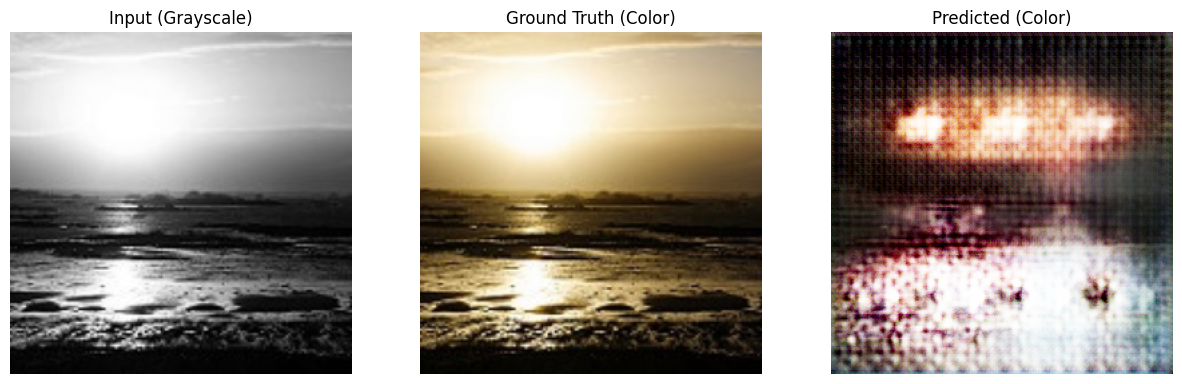

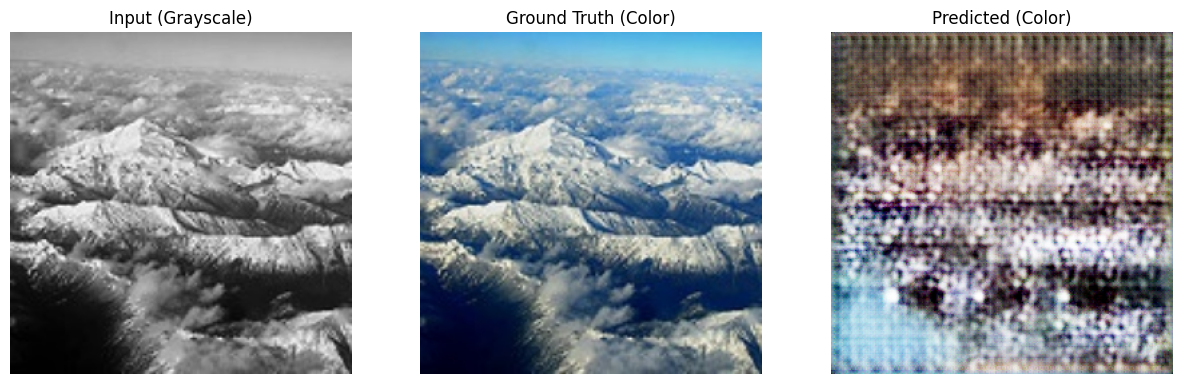

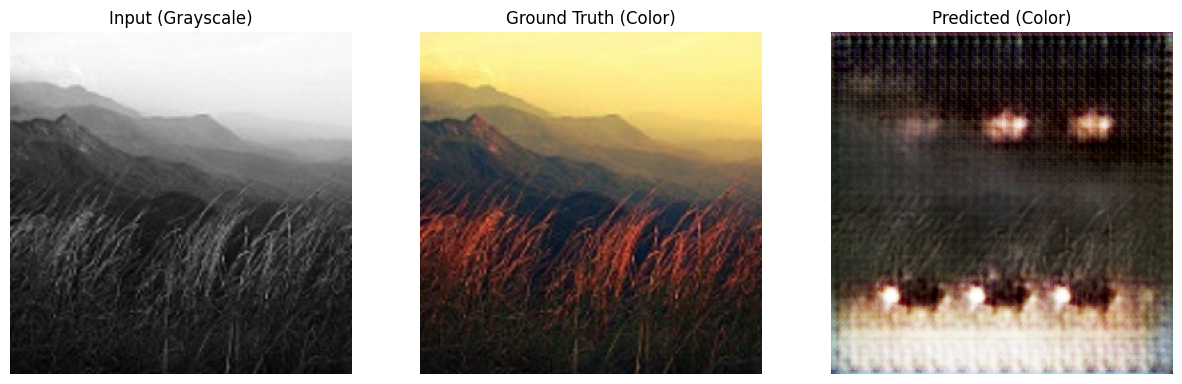

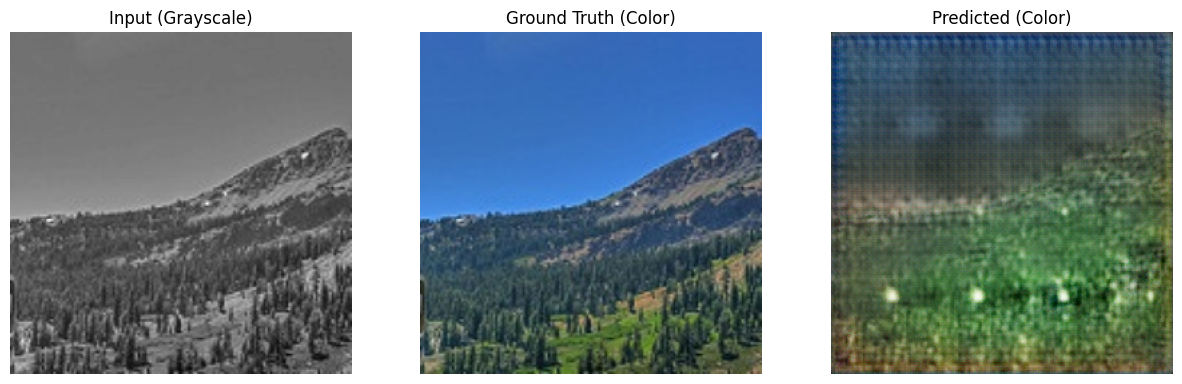

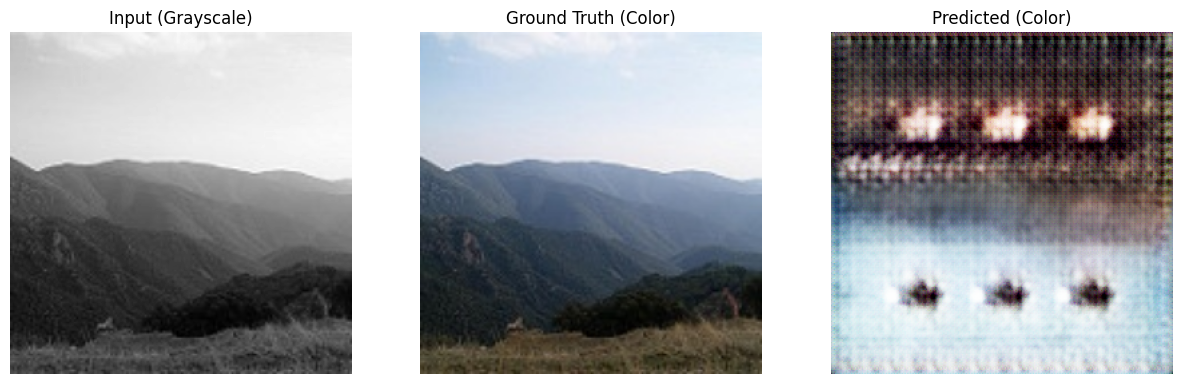

In [22]:
# Prikaz rezultata.
generate_examples(generator, test_generator, num_examples=5)